# 💧 Noiseless VQE Simulation of Water (H₂O)

This notebook applies the **Variational Quantum Eigensolver (VQE)** algorithm to compute the **ground state energy of the water molecule (H₂O)** using a **noiseless quantum simulator** and an **ansatz including both single and double excitations**. The simulation is implemented using PennyLane’s quantum chemistry tools.

### Key Features:
- **Molecular Setup**: Builds the H₂O geometry and generates the qubit-based molecular Hamiltonian using the STO-3G basis.
- **Ansatz Construction**: Combines **single and double excitations** following the UCCSD framework.
- **Optimization Strategy**: Uses the **Adam optimizer** to iteratively minimize the expectation value of the Hamiltonian.
- **Results Visualization**:
  - Convergence plot of energy vs. iteration.
  - Quantum state decomposition into basis states and amplitudes.
  - Bar plot of the most significant basis states in the final statevector.

### Purpose:
To simulate the ground state of water using a fully unitary coupled cluster approach in a **noiseless setting**, offering a reference baseline for:
- Comparing single vs. double excitation contributions,
- Evaluating optimizer performance,

In [9]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import json, os, time
from vqe_utils import excitation_ansatz, get_optimizer, set_seed, make_run_config_dict, run_signature, find_existing_run, save_run_record, ensure_dirs
from vqe_utils import RUNS_DIR, RESULTS_DIR, IMG_DIR

seed = 0
set_seed(seed)  # Reproducible runs
ensure_dirs()   # Creates runs/, results/ and images, if missing

In [10]:
# Define the atoms in the water molecule
symbols = ["O", "H", "H"]

# Define the coordinates (in Ångströms)
coordinates = np.array([
    [0.000000, 0.000000, 0.000000],  # Oxygen at origin
    [0.758602, 0.000000, 0.504284],  # Hydrogen 1
    [-0.758602, 0.000000, 0.504284]   # Hydrogen 2
])

# Define the water Hamiltonian and the number of qubits required
# Default STO-3G basis set
basis = "STO-3G"
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0, basis=basis)

# 1 spatial orbital for each H and 5 for O
# Each spatial orbital is doubly-degenerate (2 spin orbitals)
print(f"{qubits} qubits required")

14 qubits required


In [11]:
# Which orbitals are occupied (1) or unoccupied (0) in the mean-field (Hartree-Fock) solution
electrons = 10  # 1 from each H and 8 from O
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)

# Show that the first 10 orbitals are occupied
# Print the state in bra-ket notation (leftmost bit = highest-index spin orbital)
print(f"Hartree-Fock state: {'|' + ''.join(str(bit) for bit in hf) + '⟩'}")

Hartree-Fock state: |11111111110000⟩


In [12]:
# Define the number of required quantum wires / logical qubits
num_wires = qubits

# Create quantum device simulator backend
dev = qml.device("default.qubit",  # Noiseless state vector simulator
                 wires=num_wires)


@qml.qnode(dev)  # Transforms exp_energy below into a quantum node
def exp_energy(state):
    qml.BasisState(np.array(state), wires=range(num_wires))

    # Return the expectation value of the molecular Hamiltonian
    return qml.expval(hamiltonian)

# Calculate ⟨ψ_hf| hamiltonian |ψ_hf⟩ in Hartree (Ha) units
# 1 Ha = 27.2 eV
exp_energy(hf)

tensor(-72.86837737, requires_grad=True)

[reuse] loaded results/H2O_Noiseless_Adam_s0__8fe3e4bc332e.json


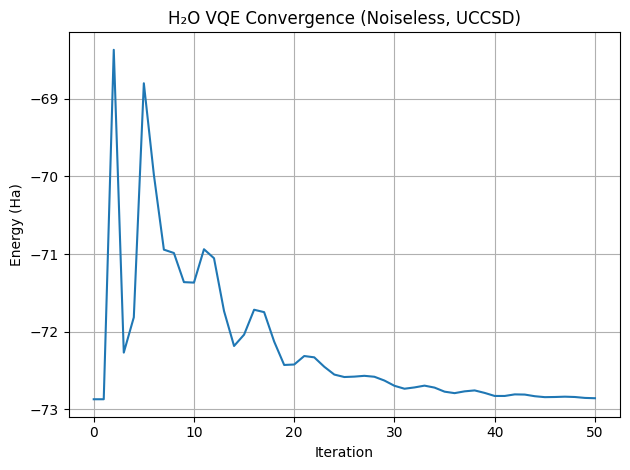

Final ground state energy = -72.85526884 Ha


In [17]:
# Generate excitation indices
singles, doubles = excitations(electrons, qubits)

# Define the VQE cost function
@qml.qnode(dev)
def cost_function(params):
    excitation_ansatz(
        params,
        wires=range(num_wires),
        hf_state=hf,
        excitations=(singles, doubles),
        excitation_type="both",          # H2O: singles + doubles (UCCSD)
    )

    # Measure the expectation value of the Hamiltonian after applying the ansatz:
    # E(theta) = ⟨ψ(theta)| H |ψ(theta)⟩
    return qml.expval(hamiltonian)

def run_vqe_with_cache(stepsize, max_iterations):
    ansatz_desc = "UCC singles+doubles (excitation_ansatz with (singles, doubles))"
    optimizer_name = "Adam"

    # Build configuration and signature (no circuit calls here)
    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iterations,
        seed=seed,
    )
    sig = run_signature(cfg)

    # Human-readable filename and signature
    fname = os.path.join(RUNS_DIR, f"H2O_Noiseless_{optimizer_name}_s{seed}__{sig}.json")
    existing = find_existing_run(RUNS_DIR, sig)

    if existing:
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] loaded {existing}")
        energy = rec["energies"]
        if "final_params" in rec:
            params = np.array(rec["final_params"], requires_grad=True)
        elif "params_by_step" in rec and rec["params_by_step"]:
            params = np.array(rec["params_by_step"][-1], requires_grad=True)
        else:
            print("[reuse] no params stored; recomputing.")
            existing = None

        # Backfill to results/
        if existing:
            base = os.path.basename(existing)
            dest = os.path.join(RESULTS_DIR, base)
            if not os.path.exists(dest):
                with open(dest, "w") as f:
                    json.dump(rec, f, indent=2)
                print(f"[mirrored-existing] {dest}")

    else:
        print("[compute] No matching run found; optimizing now.")

    if not existing:
        # Compute results if this configuration has NOT been ran before
        opt = get_optimizer(optimizer_name, stepsize=stepsize)
        params = np.zeros(len(singles) + len(doubles), requires_grad=True)
        energy = [cost_function(params)]
        for _ in range(max_iterations):
            params, e_prev = opt.step_and_cost(cost_function, params)
            energy.append(e_prev)
        energy[-1] = float(cost_function(params))

        run_record = {
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "molecule": "H2O",
            "symbols": symbols,
            "geometry": coordinates.tolist(),
            "basis": basis,
            "electrons": electrons,
            "num_wires": num_wires,
            "ansatz": ansatz_desc,
            "optimizer": {
                "name": optimizer_name,
                "stepsize": stepsize,
                "iterations_planned": max_iterations,
                "iterations_ran": len(energy) - 1,
            },
            "seed": seed,
            "energies": [float(e) for e in energy],
            "final_params": [float(x) for x in params],
            "config_hash": sig,
        }

        persisted = save_run_record(fname, run_record)
        print(f"[saved] {optimizer_name}: {fname}")
        print(f"[mirrored] {persisted}")


    return {"energy": energy, "params": params}

max_iterations = 50
stepsize = 0.2
res = run_vqe_with_cache(stepsize=stepsize, max_iterations=max_iterations)

energy = res["energy"]
params = res["params"]

# Plotting VQE convergence
plt.plot(range(len(energy)), energy)
plt.xlabel('Iteration')
plt.ylabel('Energy (Ha)')
plt.title('H₂O VQE Convergence (Noiseless, UCCSD)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{IMG_DIR}/H2O_Adam.png', dpi=300)
plt.show()

print(f"Final ground state energy = {energy[-1]:.8f} Ha")

In [14]:
num_singles = len(singles)
theta_singles = params[:num_singles]
theta_doubles = params[num_singles:]

if len(theta_singles) >= 2:
    print(f"Final single excitation parameters: {theta_singles[0]:.8f}, {theta_singles[1]:.8f}")
else:
    print(f"Final single excitation parameters: {theta_singles}")

if len(theta_doubles) >= 2:
    print(f"Final double excitation parameters: {theta_doubles[0]:.8f}, {theta_doubles[1]:.8f}")
else:
    print(f"Final double excitation parameters: {theta_doubles}")

Final single excitation parameters: 0.00932981, -0.00095137
Final double excitation parameters: 0.00648722, 0.00114997


In [15]:
@qml.qnode(dev)
def ground_state(params):
    excitation_ansatz(
        params,
        wires=range(num_wires),
        hf_state=hf,
        excitations=(singles, doubles),
        excitation_type="both"
    )

    # Return the entire quantum statevector
    return qml.state()

final_state = ground_state(params)

# Find non-zero (or near non-zero) entries
threshold = 1e-2  # Recommended smaller threshold to capture all significant amplitudes
non_zero_indices = np.where(np.abs(final_state) > threshold)[0]
non_zero_amplitudes = final_state[non_zero_indices]

# Build the full ket notation string
ket_terms = []
for idx, amp in zip(non_zero_indices, non_zero_amplitudes):
    binary_state = f"|{idx:0{num_wires}b}⟩"
    amp_str = f"{amp.real:.4f}" if np.isclose(amp.imag, 0, atol=1e-6) else f"({amp.real:.4f} + {amp.imag:.4f}j)"
    ket_terms.append(f"{amp_str}{binary_state}")

# Join all terms into one quantum state expression and print
ket_notation = " + ".join(ket_terms)
print(f"Ground state of H₂O:\n|ψ⟩ = {ket_notation}")

Ground state of H₂O:
|ψ⟩ = -0.0112|11001111111100⟩ + 0.0171|11011011111001⟩ + 0.0117|11011111110010⟩ + -0.0226|11110011110011⟩ + -0.0279|11111100110011⟩ + 0.0123|11111101101100⟩ + 0.0110|11111110010110⟩ + 0.0122|11111110011100⟩ + 0.0223|11111110110100⟩ + -0.0130|11111111001100⟩ + -0.0161|11111111011000⟩ + -0.0104|11111111100100⟩ + 0.9970|11111111110000⟩


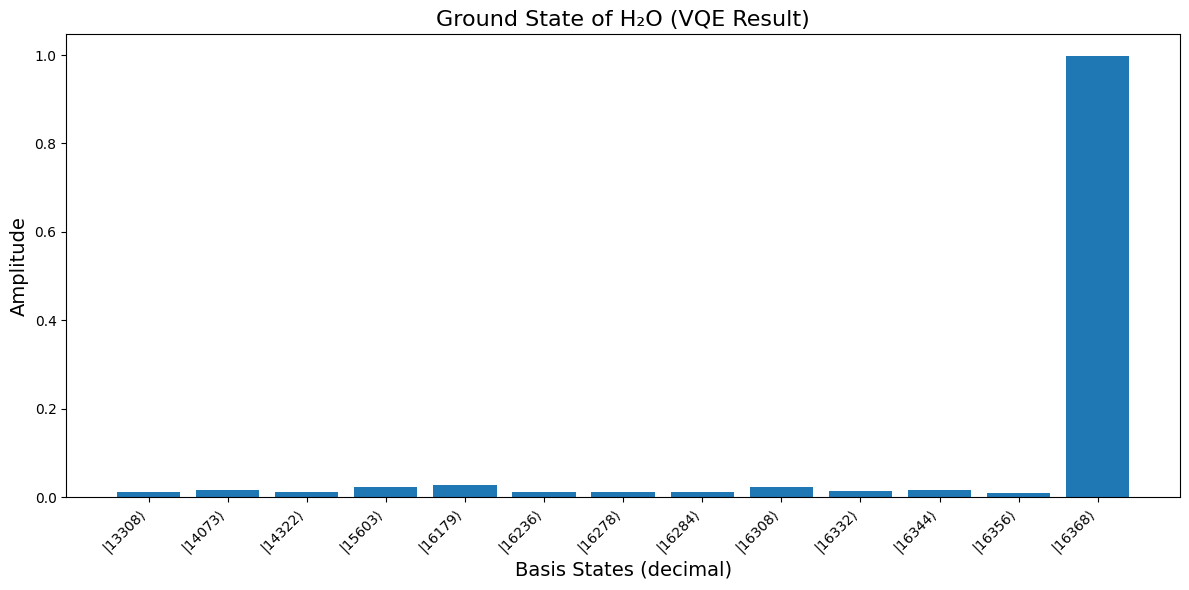

In [16]:
# Prepare labels and amplitudes for the plot (decimal labels for readability)
labels = [f"|{i}⟩" for i in non_zero_indices]
amplitudes = np.abs(non_zero_amplitudes)

plt.figure(figsize=(12, 6))
plt.bar(labels, amplitudes)
plt.xlabel('Basis States (decimal)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.title('Ground State of H₂O (VQE Result)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'{IMG_DIR}/H2O_Ground_State.png', dpi=300)
plt.show()